In [1]:
from utils import f1
from keras import callbacks
from timeit import default_timer as timer
from keras import models, losses, metrics, layers, optimizers
from keras.utils import multi_gpu_model
import tensorflow as tf
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import keras

import numpy as np
import pandas as pd

from tensorflow.python.client import device_lib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


get_available_gpus()

Using TensorFlow backend.


['/device:GPU:0', '/device:GPU:1']

In [2]:
datadir = '/home/wjk68/data/quora/'

for d in os.listdir(datadir):
    if os.path.isdir(datadir + d):
        print(d, os.listdir(datadir + d))
    else:
        print(d)

paragram_300_sl999 ['README.txt', 'paragram_300_sl999.txt']
GoogleNews-vectors-negative300 ['GoogleNews-vectors-negative300.bin']
wiki-news-300d-1M ['wiki-news-300d-1M.vec']
sample_submission.csv
train.csv
test.csv
glove.840B.300d ['glove.840B.300d.txt']
models ['wt103']


In [3]:
train = pd.read_csv(datadir + 'train.csv', usecols=[1, 2])
test = pd.read_csv(datadir + 'test.csv', usecols=[0, 1])
train.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


In [4]:
train['length'] = [len(q) for q in train['question_text']]
train['length'].describe()

count    1.306122e+06
mean     7.067884e+01
std      3.878428e+01
min      1.000000e+00
25%      4.500000e+01
50%      6.000000e+01
75%      8.500000e+01
max      1.017000e+03
Name: length, dtype: float64

In [5]:
import seaborn as sns
g = sns.FacetGrid(hue = 'target', data = train)
g.map(sns.kdeplot, 'length')

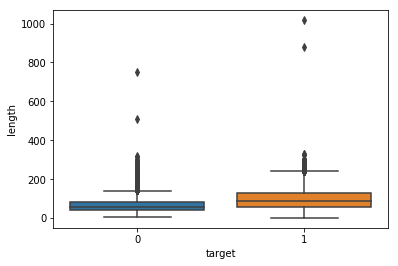

In [6]:
sns.boxplot(x = 'target', y = 'length', data = train);

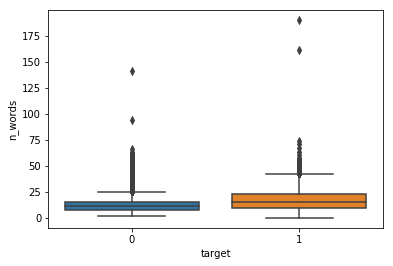

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['question_text'])
s = tokenizer.texts_to_sequences(train['question_text'])
lens = [len(i) for i in s]
train['n_words'] = lens
sns.boxplot(x = 'target', y = 'n_words', data = train)

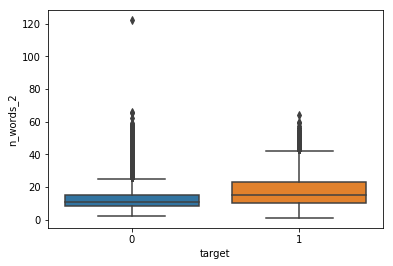

In [8]:
tokenizer = Tokenizer(filters = '')
tokenizer.fit_on_texts(train['question_text'])
s2 = tokenizer.texts_to_sequences(train['question_text'])
lens = [len(i) for i in s2]
train['n_words_2'] = lens
sns.boxplot(x = 'target', y = 'n_words_2', data = train)

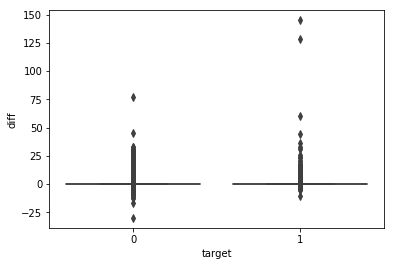

In [9]:
train['diff'] = train['n_words']  - train['n_words_2']
sns.boxplot(x = 'target', y = 'diff', data = train)

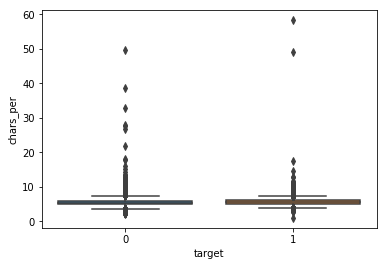

In [10]:
train['chars_per'] = train['length'] / train['n_words']
sns.boxplot(x = 'target', y = 'chars_per', data = train);

In [11]:
corrs  = train.corr()
corrs

,target,length,n_words,n_words_2,diff,chars_per
target,1.000000,0.181331,0.162895,0.162835,0.020163,0.037365
length,0.181331,1.000000,0.969009,0.967383,0.135612,0.097550
n_words,0.162895,0.969009,1.000000,0.996797,0.158772,-0.119783
n_words_2,0.162835,0.967383,0.996797,1.000000,0.079306,-0.115075
diff,0.020163,0.135612,0.158772,0.079306,1.000000,-0.072406
chars_per,0.037365,0.097550,-0.119783,-0.115075,-0.072406,1.000000


In [ ]:
s = 'this is a string with spaces'
import re
re.sub('\s', '', s)
texts = [re.sub('\s', '', s) for s in train['question_text']]

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from timeit import default_timer as timer

start = timer()
vectorizer = CountVectorizer(lowercase = False, analyzer = 'char', 
                             max_features = 100)
X = vectorizer.fit_transform(texts)
end = timer()
X

<1306122x100 sparse matrix of type '<class 'numpy.int64'>'
	with 27733474 stored elements in Compressed Sparse Row format>

In [22]:
X_arr = X.toarray()
X_arr.shape

(1306122, 100)

In [23]:
X_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
import pandas as pd
df_counts = pd.DataFrame(X_arr)
df_counts.columns = vectorizer.get_feature_names()
df_counts.head()

,!,"""",#,$,%,&,',(,),*,...,},é,ा,​,‘,’,“,”,…,√
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
vectorizer.get_feature_names()

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 'é',
 'ा',
 '\u200b',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '√']

In [25]:
df_train = pd.concat([train, df_counts], axis = 1)
corrs = df_train.corr()
corrs['target']

target       1.000000
length       0.181331
n_words      0.162895
n_words_2    0.162835
diff         0.020163
chars_per    0.037365
!            0.031410
"            0.024399
#            0.004229
$           -0.001863
%            0.006405
&            0.013174
'            0.063044
(            0.004874
)            0.005141
*            0.012785
+           -0.010186
,            0.117177
-            0.046527
.            0.048505
/            0.000358
0           -0.013187
1           -0.016200
2           -0.020039
3           -0.012231
4           -0.008893
5           -0.011110
6           -0.006319
7           -0.013567
8           -0.011078
               ...   
i            0.155575
j            0.030171
k            0.077828
l            0.158930
m            0.120216
n            0.143459
o            0.109432
p            0.092348
q            0.009401
r            0.131427
s            0.173433
t            0.134379
u            0.104839
v            0.063802
w         

In [27]:
corrs['target'].sort_values()

H           -0.032506
2           -0.020039
1           -0.016200
7           -0.013567
0           -0.013187
3           -0.012231
5           -0.011110
8           -0.011078
+           -0.010186
4           -0.008893
V           -0.007495
X           -0.007151
6           -0.006319
=           -0.005873
​           -0.003228
√           -0.002888
^           -0.002881
|           -0.002154
é           -0.002128
$           -0.001863
>           -0.001658
<           -0.001651
ा           -0.001452
/            0.000358
_            0.000427
9            0.000719
F            0.000738
[            0.001071
]            0.001845
E            0.002346
               ...   
'            0.063044
v            0.063802
Q            0.069074
’            0.070468
g            0.071612
?            0.072250
k            0.077828
A            0.079365
w            0.079395
b            0.081391
p            0.092348
u            0.104839
o            0.109432
,            0.117177
m         

In [28]:
from keras.models import *
from keras.layers import *

In [33]:
start = timer()
tokenizer = Tokenizer(filters = '', char_level=True, lower = False)
tokenizer.fit_on_texts(texts)
end = timer()

In [34]:
chars = tokenizer.texts_to_sequences(texts)

In [39]:
nchars = len(tokenizer.word_counts) + 1
nchars

2045

In [35]:
len(chars)

1306122

In [37]:
from keras.preprocessing.sequence import pad_sequences

lens = [len(c) for c in chars]
chars = pad_sequences(chars, max(lens))
chars = np.array(chars, dtype = int)
chars.shape

(1306122, 973)

In [49]:
def retrieve_saved_data():
    """Retrieve already formatted data"""
    
    sequences = np.load('sequences.npy')
    test_sequences = np.load('test_sequences.npy')
    labels = np.load('labels.npy')
    
    iw = []
    with open('index_word.json', 'r') as f:
        for l in f:
            iw.append(json.loads(l))

    index_word = iw[0]
    index_word = {int(key): word for key, word in index_word.items()}

    wi = []
    with open('word_index.json', 'r') as f:
        for l in f:
            wi.append(json.loads(l))

    word_index = wi[0]
    word_index = {word: int(index) for word, index in word_index.items()}
    
    vs = len(word_index) + 1
    
    return sequences, labels, test_sequences, word_index, index_word, vs

sequences, labels, test_sequences, word_index, index_word, vs = retrieve_saved_data()
vs

59728

In [45]:
embedded_chars.shape

TensorShape([Dimension(None), Dimension(973), Dimension(100)])

In [46]:
sequences = pad_sequences(sequences, chars.shape[1])

In [48]:
seq_lstm.shape

TensorShape([Dimension(None), Dimension(64)])

In [51]:
with tf.device('cpu/:0'):
    
    sequence_input = Input(shape = (sequences.shape[1],), dtype = 'int32')
    char_input = Input(shape = (chars.shape[1],), dtype = 'int32')

    sequence_embedding = Embedding(vs, 100, name = 'sequence_embedding')
    embedded_sequences = sequence_embedding(sequence_input)
    seq_lstm = CuDNNLSTM(64, name = 'seq_lstm')(embedded_sequences)

    char_embedding = Embedding(nchars, 100, name = 'char_embedding')
    embedded_chars = char_embedding(char_input)
    char_lstm = CuDNNLSTM(64, name = 'char_lstm')(embedded_chars)

    combined = Concatenate()([seq_lstm, char_lstm])

    fc1 = Dense(128, activation = 'relu')(combined)
    fc1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation = 'relu')(fc1)
    fc2 = Dropout(0.5)(fc2)
    out = Dense(1, activation = 'sigmoid')(fc2)

    model = Model(inputs = [sequence_input, char_input], outputs = [out])

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 492)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 973)          0                                            
__________________________________________________________________________________________________
sequence_embedding (Embedding)  (None, 492, 100)     5972800     input_11[0][0]                   
__________________________________________________________________________________________________
char_embedding (Embedding)      (None, 973, 100)     204500      input_12[0][0]                   
__________________________________________________________________________________________________
seq_lstm (

In [53]:
from keras.utils import * 
model = multi_gpu_model(model, gpus = 2)

In [56]:
model.compile(optimizer = optimizers.Adam(), loss = losses.binary_crossentropy, 
              metrics = [metrics.binary_accuracy, metrics.binary_crossentropy, f1])

In [55]:
model.fit([sequences, chars], labels, epochs = 2, batch_size = 1024,
          validation_split = 0.3)

Train on 914285 samples, validate on 391837 samples
Epoch 1/2
914285/914285 [==============================] - 511s 559us/step - loss: 0.1386 - binary_accuracy: 0.9505 - binary_crossentropy: 0.1386 - val_loss: 0.1133 - val_binary_accuracy: 0.9549 - val_binary_crossentropy: 0.1133
Epoch 2/2
914285/914285 [==============================] - 397s 434us/step - loss: 0.1047 - binary_accuracy: 0.9587 - binary_crossentropy: 0.1047 - val_loss: 0.1140 - val_binary_accuracy: 0.9527 - val_binary_crossentropy: 0.1140


In [ ]:
model_name = 'combined'

callback_list = [callbacks.EarlyStopping(monitor='val_loss', patience=3),
                     callbacks.ModelCheckpoint(filepath=f'models/{model_name}.h5',
                                               save_best_only=True, save_weights_only=True)]

model.fit([sequences, chars], labels, epochs = 12, batch_size = 1024,
          validation_split = 0.3, callbacks=callback_list)

Train on 914285 samples, validate on 391837 samples
Epoch 1/12
  7168/914285 [..............................] - ETA: 8:12 - loss: 0.0899 - binary_accuracy: 0.9633 - binary_crossentropy: 0.0899 - f1: 0.6952

In [32]:
len(texts)

1306122

In [30]:
len(s)

28

In [ ]:

embeddings_words = Embedding(vs, 50)

In [47]:
import re

cap = re.compile(r'[A-Z]')
cap

re.compile(r'[A-Z]', re.UNICODE)

In [5]:
pd.options.display.max_colwidth = 200
list(train.loc[train['target'] == 1, 'question_text'].sample(10))

["Was 2016 the worst year for cheaters? Hillary cheated Bernie, and Russia tried to dirty Hillary's reputation because they knew she was going to win.",
 'Can humans and sheep produce offspring?',
 'How did Donald J. Trump become a psychopath? He seem to care about his money more than anything on this planet.',
 'How can I download the Blue Whale Challenge original game?',
 'Why the Pakistani media and Pakistani people gave no importance to the statements of Indian media and Indian people?',
 'Is using the word “Nazi” instead of “NSDAP” a sign you are brainwashed?',
 'What do Sri Lankan girls think about Bangladeshi guys in terms of dating and marriage?',
 "What was the major embarrassment of 2017: caste, corruption, Modi's painful acronyms or Venkaiah Naidu's worshiping statements?",
 "Instead of embarrassing the US, why doesn't Donald Trump realise the 1st rule for holding a position of that magnitude? Keep your mouth shut. If he’s smart enough to get the President’s job, he knows hi

In [6]:
def format_sequence(s):
    """Add spaces around punctuation."""

    # Add spaces around punctuation
    s = re.sub(
        r'(?<=[^\s])(?=[“”!\"#$%&()*+,./:;<=>?@[\]^_`{|}~\t\n])|(?=[^\s])(?<=[“”!\"#$%&()*+,./:;<=>?@[\]^_`{|}~\t\n])', r' ', s)

    # Remove double spaces
    s = re.sub(r'\s\s', ' ', s)
    return s


def format_data(df_train, df_test,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                keep_freq=5):
    """Format text data"""
    texts = list(df_train['question_text'])
    texts = [format_sequence(t) for t in texts]

    # Fit once to get word counts
    tokenizer = Tokenizer(lower=False, filters=filters)
    tokenizer.fit_on_texts(texts)
    wc = tokenizer.word_counts
    wc = sorted(wc.items(), key=lambda x: x[1], reverse=True)
    keep = [w for w in wc if w[1] >= keep_freq]

    # Create again to limit to top words
    tokenizer = Tokenizer(num_words=len(keep),
                          lower=False,
                          filters=filters)
    tokenizer.fit_on_texts(texts)
    word_index = dict(list(tokenizer.word_index.items())[:len(keep)])
    index_word = dict(list(tokenizer.index_word.items())[:len(keep)])
    wc = tokenizer.word_counts
    wc = sorted(wc.items(), key=lambda x: x[1], reverse=True)[:len(keep)]

    sequences = tokenizer.texts_to_sequences(texts)
    lens = [len(s) for s in sequences]
    
    vs = tokenizer.num_words + 1

    # Pad sequences to have same length
    sequences = pad_sequences(sequences, max(lens))
    sequences = np.array(sequences, dtype=int)

    # Labels
    labels = np.array(df_train['target'], dtype=int)

    # Test data
    test_texts = list(df_test['question_text'])
    test_texts = [format_sequence(t) for t in test_texts]
    test_sequences = tokenizer.texts_to_sequences(test_texts)
    test_sequences = pad_sequences(test_sequences, max(lens))
    test_sequences = np.array(test_sequences, dtype=int)

    return sequences, labels, test_sequences, word_index, index_word, wc, vs

In [7]:
filters = ''
sequences, labels, test_sequences, word_index, index_word, wc, vs = format_data(train, test,
                                                                            filters=filters, keep_freq=5)
print(f'There are {vs} words in the vocab.')
print(f'There are {len(word_index)} words in the vocab.')

There are 59728 words in the vocab.
There are 59727 words in the vocab.


In [26]:
np.save('sequences.npy', sequences)
np.save('test_sequences.npy', test_sequences)
np.save('labels.npy', labels)

In [10]:
import json

with open('word_index.json', 'w') as f:
    f.write(json.dumps(word_index))

1068885

In [11]:
with open('index_word.json', 'w') as f:
    f.write(json.dumps(index_word))

1188339

In [4]:
def retrieve_saved_data():
    """Retrieve already formatted data"""
    
    sequences = np.load('sequences.npy')
    test_sequences = np.load('test_sequences.npy')
    labels = np.load('labels.npy')
    
    iw = []
    with open('index_word.json', 'r') as f:
        for l in f:
            iw.append(json.loads(l))

    index_word = iw[0]
    index_word = {int(key): word for key, word in index_word.items()}

    wi = []
    with open('word_index.json', 'r') as f:
        for l in f:
            wi.append(json.loads(l))

    word_index = wi[0]
    word_index = {word: int(index) for word, index in word_index.items()}
    
    vs = len(word_index) + 1
    
    return sequences, labels, test_sequences, word_index, index_word, vs

In [5]:
sequences, labels, test_sequences, word_index, index_word, vs = retrieve_saved_data()
vs

59728

In [6]:
multi_gpu = len(get_available_gpus()) > 1

def get_model(vs, model_name, lstm_layer, embeddings = None):

    if multi_gpu:
        device = '/cpu:0'
    else:
        device = '/gpu:0'

    with tf.device(device):
        model = models.Sequential()
        if embeddings is not None:
            model.add(layers.Embedding(vs, embeddings.shape[1], 
                                       weights = [embeddings]))
        else:
            model.add(layers.Embedding(vs, 50))
            
        # model.add(layers.Masking(mask_value = 0.))
        model.add(layers.Bidirectional(lstm_layer))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(1, activation='sigmoid'))

    if multi_gpu:
        model = multi_gpu_model(model, gpus=len(get_available_gpus()))

    model.compile(optimizer=optimizers.Adam(),
                  loss=losses.binary_crossentropy,
                  metrics=[metrics.binary_accuracy,  metrics.binary_crossentropy, f1])

    callback_list = [callbacks.EarlyStopping(monitor='val_loss', patience=2),
                     callbacks.ModelCheckpoint(filepath=f'models/{model_name}.h5',
                                               save_best_only=True, save_weights_only=False)]

    model.callbacks = callback_list

    return model

In [51]:
model = get_model(vs, 'cudnn_model_severe', layers.CuDNNLSTM(64, return_sequences = False))
model.summary()

InternalError: GPU sync failed

In [52]:
start = timer()
history = model.fit(sequences, labels, callbacks=model.callbacks,
                    epochs = 2, validation_split = 0.3,
                    batch_size=8192, verbose = 1)
end = timer()
print(f'\nCuDNN LSTM model took {end - start:.2f} seconds.')

Train on 914285 samples, validate on 391837 samples
Epoch 1/2


InternalError: GPU sync failed

In [33]:
model = models.load_model('models/cudnn_model_severe.h5', custom_objects = {'f1': f1})
weights = model.get_layer(index = 3)
embeddings = weights.get_weights()[0]
embeddings = np.nan_to_num(embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1)))

In [9]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n = 10, least = False):
    """Find closest words to a query word in embeddings"""
    
    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)
            
            if least:
                idxs = np.argsort(dists)[:n]
            else:
                # Sort indexes in reverse order
                idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]
            
    print(f'Query: {query}\n')
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [35]:
find_closest('the', embeddings, word_index, index_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: Shameless       Cosine Similarity: 0.5835999846458435
Word: beautiful       Cosine Similarity: 0.5300999879837036
Word: bush            Cosine Similarity: 0.5097000002861023
Word: Gong            Cosine Similarity: 0.48829999566078186
Word: West            Cosine Similarity: 0.4878999888896942
Word: polluted        Cosine Similarity: 0.4844000041484833
Word: favourably      Cosine Similarity: 0.48410001397132874
Word: b-              Cosine Similarity: 0.47769999504089355
Word: Farrah          Cosine Similarity: 0.476500004529953


In [41]:
find_closest('What', embeddings, word_index, index_word, n = 10)

Query: What

Word: What            Cosine Similarity: 1.0
Word: partner         Cosine Similarity: 0.9140999913215637
Word: analysis        Cosine Similarity: 0.9042999744415283
Word: Goku            Cosine Similarity: 0.9035999774932861
Word: grand           Cosine Similarity: 0.9021999835968018
Word: marries         Cosine Similarity: 0.9018999934196472
Word: accounting      Cosine Similarity: 0.9014999866485596
Word: stressed        Cosine Similarity: 0.8956999778747559
Word: internal        Cosine Similarity: 0.8952999711036682
Word: trait           Cosine Similarity: 0.8942000269889832


In [37]:
embeddings[word_index['How']]

array([-0.2280687 ,  0.00167013, -0.19859864, -0.14022546, -0.1431441 ,
       -0.20457116,  0.0107323 , -0.12995672, -0.02073253,  0.15847164,
       -0.17600329,  0.11368658, -0.02655024,  0.2282364 ,  0.00058332,
       -0.2165317 ,  0.0007019 ,  0.20995955,  0.10638271, -0.02124753,
       -0.23224181, -0.00416978, -0.00148469, -0.07528396,  0.23424476,
        0.24503402, -0.01487264,  0.20249258,  0.05425905, -0.03641619,
       -0.22361198,  0.01788967,  0.18893792, -0.00886964,  0.02122222,
        0.00866623, -0.10659754, -0.02448355, -0.20074952,  0.20973067,
       -0.00746605, -0.03333661,  0.0397941 ,  0.21455634, -0.15770036,
        0.11095827, -0.07149883, -0.05746122, -0.28492412,  0.07802176],
      dtype=float32)

In [42]:
np.dot(embeddings[word_index['the']], embeddings[word_index['The']])

0.09921692

In [39]:
np.dot(embeddings[word_index['What']], embeddings[word_index['How']])

0.60075325

In [8]:
def normalize(arr):
    return np.nan_to_num(arr / np.linalg.norm(arr, axis = 1).reshape((-1, 1)))

In [10]:
glove_embeddings = np.load('glove_embeddings.npy')
glove_embeddings = normalize(glove_embeddings)
fasttext_embeddings = np.load('fasttext_embeddings.npy')
fasttext_embeddings = normalize(fasttext_embeddings)

/home/wjk68/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [11]:
model = get_model(vs, 'glove_embeddings', layers.CuDNNLSTM(32), glove_embeddings)
start = timer()
history = model.fit(sequences, labels, callbacks=model.callbacks,
                    epochs = 2, validation_split = 0.3,
                    batch_size=512, verbose = 1)
end = timer()
print(f'\nCuDNN LSTM model took {end - start:.2f} seconds.')

Train on 914285 samples, validate on 391837 samples
Epoch 1/2
914285/914285 [==============================] - 485s 530us/step - loss: 0.1336 - binary_accuracy: 0.9519 - binary_crossentropy: 0.1336 - f1: 0.5128 - val_loss: 0.1127 - val_binary_accuracy: 0.9556 - val_binary_crossentropy: 0.1127 - val_f1: 0.6005
Epoch 2/2
914285/914285 [==============================] - 485s 530us/step - loss: 0.1019 - binary_accuracy: 0.9603 - binary_crossentropy: 0.1019 - f1: 0.6417 - val_loss: 0.1126 - val_binary_accuracy: 0.9563 - val_binary_crossentropy: 0.1126 - val_f1: 0.6146

CuDNN LSTM model took 972.47 seconds.


# CNN Attempt

In [17]:
from keras.models import *
from keras.layers import *

embedding_matrix = glove_embeddings

MAX_SEQUENCE_LENGTH = sequences.shape[1]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(embedding_matrix.shape[0], 
                             embedding_matrix.shape[1],
                             weights = [embedding_matrix],
                             name = 'embedding')

embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(5)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
l_dense = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(l_dense)
                          
model = Model(inputs = [sequence_input], output = [preds])

model.compile(optimizer = optimizers.Adam(), loss = losses.binary_crossentropy,
              metrics = [metrics.binary_crossentropy, metrics.binary_accuracy,
                         f1])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 492)               0         
_________________________________________________________________
embedding (Embedding)        (None, 492, 300)          17918400  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 488, 128)          192128    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 97, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 93, 128)           82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 14, 128)           82048     
__________

/home/wjk68/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [18]:
model_name = 'cnn'

callback_list = [callbacks.EarlyStopping(monitor='val_loss', patience=2),
                 callbacks.ModelCheckpoint(filepath=f'models/{model_name}.h5',
                                           save_best_only=True, save_weights_only=False)]

In [19]:
history = model.fit(sequences, labels, validation_split = 0.3, 
                    callbacks = callback_list, epochs = 5,
                    batch_size = 2048)

Train on 914285 samples, validate on 391837 samples
Epoch 1/5
914285/914285 [==============================] - 198s 216us/step - loss: 0.2455 - binary_crossentropy: 0.2455 - binary_accuracy: 0.9382 - f1: 0.0000e+00 - val_loss: 0.2330 - val_binary_crossentropy: 0.2330 - val_binary_accuracy: 0.9380 - val_f1: 0.0000e+00
Epoch 2/5
914285/914285 [==============================] - 194s 212us/step - loss: 0.2366 - binary_crossentropy: 0.2366 - binary_accuracy: 0.9382 - f1: 9.7808e-05 - val_loss: 0.2341 - val_binary_crossentropy: 0.2341 - val_binary_accuracy: 0.9380 - val_f1: 0.0000e+00
Epoch 3/5
914285/914285 [==============================] - 194s 212us/step - loss: 0.2365 - binary_crossentropy: 0.2365 - binary_accuracy: 0.9382 - f1: 3.6721e-05 - val_loss: 0.2329 - val_binary_crossentropy: 0.2329 - val_binary_accuracy: 0.9380 - val_f1: 0.0000e+00
Epoch 4/5
914285/914285 [==============================] - 193s 211us/step - loss: 0.2359 - binary_crossentropy: 0.2359 - binary_accuracy: 0.9382 -

In [25]:
train

NameError: name 'train' is not defined

In [23]:
e = model.get_layer('embedding')
w = normalize(e.get_weights()[0])

/home/wjk68/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [24]:
find_closest('What', w, word_index, index_word)

Query: What

Word: What            Cosine Similarity: 1.0
Word: Why             Cosine Similarity: 0.7633000016212463
Word: How             Cosine Similarity: 0.737500011920929
Word: Does            Cosine Similarity: 0.7138000130653381
Word: That            Cosine Similarity: 0.6886000037193298
Word: Where           Cosine Similarity: 0.6687999963760376
Word: Is              Cosine Similarity: 0.6633999943733215
Word: Did             Cosine Similarity: 0.6583999991416931
Word: Can             Cosine Similarity: 0.6425999999046326
Word: Know            Cosine Similarity: 0.6338000297546387


In [47]:
np.dot(embeddings[word_index['What']], glove_embeddings[word_index['What']])

ValueError: shapes (50,) and (300,) not aligned: 50 (dim 0) != 300 (dim 0)

In [17]:
find_closest('What', fasttext_embeddings, word_index, index_word)

Query: What

Word: What            Cosine Similarity: 1.0
Word: How             Cosine Similarity: 0.7607
Word: That            Cosine Similarity: 0.758
Word: Which           Cosine Similarity: 0.7509
Word: Where           Cosine Similarity: 0.7486
Word: Why             Cosine Similarity: 0.7375
Word: Now             Cosine Similarity: 0.7356
Word: Whatever        Cosine Similarity: 0.712
Word: So              Cosine Similarity: 0.7073
Word: Do              Cosine Similarity: 0.7065


In [ ]:
find_closest('What', embeddings, word_index, index_word)

In [ ]:
glove_embeddings.shape, fasttext_embeddings.shape

In [21]:
model = get_model(vs, 'glove_model', layers.CuDNNLSTM(64), embeddings = glove_embeddings)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_2_input (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None)         0           embedding_2_input[0][0]          
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None)         0           embedding_2_input[0][0]          
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            18116161    lambda_3[0][0]                   
                                                                 lambda_4[0][0]                   
__________

In [23]:
history = model.fit(sequences, labels, 
                    callbacks = model.callbacks,
                    epochs = 10, validation_split = 0.3, 
                    batch_size = 2048)

Train on 914285 samples, validate on 391837 samples
Epoch 1/10
914285/914285 [==============================] - 395s 432us/step - loss: 0.0935 - binary_accuracy: 0.9631 - binary_crossentropy: 0.0935 - f1: 0.6749 - val_loss: 0.1222 - val_binary_accuracy: 0.9550 - val_binary_crossentropy: 0.1222 - val_f1: 0.5875
Epoch 2/10
914285/914285 [==============================] - 395s 433us/step - loss: 0.0813 - binary_accuracy: 0.9677 - binary_crossentropy: 0.0813 - f1: 0.7199 - val_loss: 0.1418 - val_binary_accuracy: 0.9543 - val_binary_crossentropy: 0.1418 - val_f1: 0.6016
Epoch 3/10
914285/914285 [==============================] - 395s 432us/step - loss: 0.0695 - binary_accuracy: 0.9721 - binary_crossentropy: 0.0695 - f1: 0.7617 - val_loss: 0.1566 - val_binary_accuracy: 0.9522 - val_binary_crossentropy: 0.1566 - val_f1: 0.5762


In [ ]:
import json

with open('glove_embeddings.json', 'w') as f:
    f.write(json.dumps(glove_embeddings))

In [ ]:
glove_embeddings['the']

In [ ]:
find_closest('the', glove_embeddings, word_index, index_word, least = True)

In [ ]:
keep_words = [k[0] for k in keep]
ord(keep_words[-1][-1])

In [ ]:
EMBEDDING_FILE = '/home/wjk68/data/quora/glove.840B.300d/glove.840B.300d.txt'
    
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

In [ ]:
glove_embeddings = np.zeros((vs, len(embeddings_index['the'])))

not_in = 0
for w, i in word_index.items():
    if w in embeddings_index.keys():
        glove_embeddings[i, :] = embeddings_index[w]
    else:
        not_in += 1
        
print(f'There are {not_in} words with no pre-trained embeddings.')

In [ ]:
import sys
sys.getsizeof(embeddings_index) / 1e9

In [ ]:
EMBEDDING_FILE = '/home/wjk68/data/quora/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
fasttext_embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

In [ ]:
fasttext_embeddings = np.zeros((vs, len(embeddings_index['the'])))

not_in = 0

for w, i in word_index.items():
    if w in fasttext_embeddings_index.keys():
        fasttext_embeddings[i, :] = fasttext_embeddings_index[w]
    else:
        not_in += 1
        
print(f'There are {not_in} words with no pre-trained embeddings.')

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = '/home/wjk68/data/quora/glove.840B.300d/glove.840B.300d.txt'
    
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [ ]:
glove_embeddings = 

In [ ]:
ord('"')

In [ ]:
chr(8221)

In [ ]:
chr(8217)

In [ ]:
weights.shape

In [ ]:
len(keep)

In [ ]:
keep_words = [x[0] for x in keep]
len(keep_words)

In [ ]:
index_word[58635]

In [ ]:
keep[-1]

In [ ]:
word_index

In [ ]:
wi = dict(list(word_index.items())[:len(keep)])

In [ ]:
word_index = {word: index for word, index in word_index.items() if word in keep_words}

In [ ]:
len(word_index)

In [ ]:
index_word = {index: word for word, index in word_index.items()}
len(index_word)

In [ ]:
start = timer()
cudnn_model = models.Sequential()
cudnn_model.add(layers.Embedding(vs, 50))
cudnn_model.add(layers.CuDNNLSTM(64, return_sequences=False))
cudnn_model.add(layers.Dense(64, activation='relu'))
cudnn_model.add(layers.Dropout(0.5))
cudnn_model.add(layers.Dense(1, activation='sigmoid'))

cudnn_model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy)
_ = cudnn_model.fit(sequences, labels, batch_size=8192, epochs = 1)
end = timer()
print(f'\nCuDNN LSTM model took {end - start:.2f} seconds.')

In [ ]:
start = timer()
model = models.Sequential()
model.add(layers.Embedding(vs, 50))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy)
_ = model.fit(sequences, labels, batch_size=8192, epochs = 1)
end = timer()
print(f'\nKeras LSTM model took {end - start:.2f} seconds.')

In [ ]:
model = get_model(vs, 'lstm_model', layers.LSTM(64, return_sequences = False))
model.summary()

In [ ]:
start = timer()
history = cudnn_model.fit(sequences, labels,
                          batch_size=8192, epochs=1)
end = timer()
print(f'\nCuDNN LSTM model took {end - start:.2f} seconds.')

In [ ]:
start = timer()
history = model.fit(sequences, labels,
                          batch_size=8192, epochs=1,
                          verbose=1, validation_split=0.2,
                          callbacks=model.callbacks)
end = timer()
print(f'\nKeras LSTM model took {end - start:.2f} seconds.')

In [ ]:
vs = len(word_index) + 1

# Create model on cpu
with tf.device('/cpu:0'):
    model = models.Sequential()
    model.add(layers.Embedding(vs, 50))
    model.add(layers.Bidirectional(
        layers.CuDNNLSTM(64, return_sequences=False)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

model = multi_gpu_model(model, gpus=len(get_available_gpus()))
model.summary()

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy,  metrics.binary_crossentropy, f1])


model_name = 'first_try'

callback_list = [callbacks.EarlyStopping(monitor='val_loss', patience=2),
                 callbacks.ModelCheckpoint(filepath=f'models/{model_name}.h5',
                                           save_best_only=True, save_weights_only=False)]

In [ ]:
start = timer()
history = model.fit(
    sequences,
    labels,
    batch_size=8192,
    epochs=10,
    verbose=1,
    validation_split=0.2,
    callbacks=callback_list)
end = timer()

In [ ]:
print(f'{end - start:.2f} seconds for CuDNN LSTM layer.')

In [ ]:
# Create model on cpu
with tf.device('/cpu:0'):
    model = models.Sequential()
    model.add(layers.Embedding(vs, 50))
    model.add(layers.LSTM(64, return_sequences=False,
                          dropout=0.5, recurrent_dropout=0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

model = multi_gpu_model(model, gpus=len(get_available_gpus()))

model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy,  metrics.binary_crossentropy, f1])


model_name = 'first_try'

callback_list = [callbacks.EarlyStopping(monitor='val_loss', patience=2),
                 callbacks.ModelCheckpoint(filepath=f'models/{model_name}.h5',
                                           save_best_only=True, save_weights_only=False)]

model.summary()

In [ ]:
start = timer()
history = model.fit(
    sequences,
    labels,
    batch_size=8192,
    epochs=10,
    verbose=1,
    validation_split=0.2,
    callbacks=callback_list)
end = timer()

In [ ]:
print(f'{end - start:.2f} seconds for LSTM version.')

In [ ]:
model = models.load_model('models/first_try.h5',
                          custom_objects={'f1': f1})

In [ ]:
test = pd.read_csv(datadir + 'test.csv')
test.head()

In [ ]:
test_texts = list(test['question_text'])
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, max(lens))
test_sequences = np.array(test_sequences, dtype=int)
test_sequences.shape

In [ ]:
predictions = model.predict(test_sequences, batch_size=8192,
                            verbose=1)
predictions.shape

In [ ]:
predictions[0], test_texts[0]

In [ ]:
predictions[1], test_texts[1]

In [ ]:
i = 0

for ii, p in enumerate(predictions):
    if p > 0.5:
        i += 1
        print(p, test_texts[ii])
        if i > 10:
            break

In [ ]:
embeddings_dirs = ['paragram_300_sl999/', 'glove.840B.300d/']
glove_dir = datadir + embeddings_dirs[1] + 'glove.840B.300d.txt'


def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(glove_dir))

In [ ]:
len(embeddings_index)

In [ ]:
texts = list(train[''])

In [ ]:
!wc - l / home/wjk68/data/quora/paragram_300_sl999/paragram_300_sl999.txt

In [ ]:
!wc - l / home/wjk68/data/quora/glove.840B.300d/glove.840B.300d.txt

In [ ]:
embeddings_dirs = ['paragram_300_sl999/', 'glove.840B.300d/']
paragram = np.loadtxt(
    datadir + embeddings_dirs[0] + 'paragram_300_sl999.txt', dtype=str)
paragram.shape

In [ ]:
os.listdir(datadir + '/' + 'paragram_300_sl999')